In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import scipy as sp
import seaborn as sb
import sklearn
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
events = pd.read_csv('football-events/events.csv')
games = pd.read_csv('football-events/ginf.csv')
shots = events[(events.event_type==1)]

# Data Validation

In [4]:
#Checks whether names are not invalid within the same game
assert events.groupby(['id_odsp', 'side'])['event_team'].nunique().unique()[0] == 1

# Data preparation and MLP instantiation

In [5]:
shots_prediction = shots.iloc[:,-6:]
dummies = pd.get_dummies(shots_prediction, columns=['location', 'bodypart','assist_method', 'situation'])
dummies.columns = ['is_goal', 'fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right', 'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range', 'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header', 'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']

In [6]:
shots_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229135 entries, 0 to 941006
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   is_goal        229135 non-null  int64  
 1   location       229135 non-null  float64
 2   bodypart       229135 non-null  float64
 3   assist_method  229135 non-null  int64  
 4   situation      229135 non-null  float64
 5   fast_break     229135 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 12.2 MB


In [7]:
X = dummies.iloc[:,1:]
y = dummies.iloc[:,0]

In [8]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)
mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(28, 28, 28, 28), max_iter=2000, activation='relu')
mlp.fit(X_train, y_train)

CPU times: user 23.6 s, sys: 2.25 ms, total: 23.6 s
Wall time: 23.7 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(28, 28, 28, 28), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

# Confustion Matrix and metrics analysis

In [9]:
predict = mlp.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test,predict))
print('Report:')
print(classification_report(y_test,predict))

Confusion Matrix:
[[70771   923]
 [ 6214  2290]]
Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



In [10]:
accuracy = mlp.score(X_test, y_test)
print('The accuracy of classifying whether a shot is goal or not is {:.2f} %.'.format(accuracy*100))

The accuracy of classifying whether a shot is goal or not is 91.10 %.


# Join xG with original dataset

In [11]:
dummies['xG'] = mlp.predict_proba(X)[:,1]
dummies = dummies[['xG']].copy()
dataWithXG = shots.join(dummies[['xG']])
matchXG = dataWithXG.groupby(['id_odsp', 'side'])['xG'].sum().reset_index()

In [12]:
matchXG

,id_odsp,side,xG
0,004f4ING/,1,1.413347
1,004f4ING/,2,0.453106
2,00LMl81F/,1,2.949324
3,00LMl81F/,2,1.608309
4,00OX4xFp/,1,1.166929
...,...,...,...
18139,zyKwAQxf/,2,1.218277
18140,zyrHmI8P/,1,2.183775
18141,zyrHmI8P/,2,1.008775
18142,zyzdxP10/,1,1.587103


#### TODO: Insert nºAttempts nºCorners nºFouls nºFirst Yellow Card nº Second Yellow Cards, nº Red Cards, nº Free kicks nºoffside

## Inserting the other dependend variables

In [13]:
# Number of shots
attempts = events[(events.event_type==1)]
shotsSorted = attempts.groupby(['id_odsp', 'side']).count().reset_index()
shotsClean = shotsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"shot_count"})

# Number of corners
corners = events[(events.event_type==2)]
cornersSorted = corners.groupby(['id_odsp', 'side']).count().reset_index()
cornersClean = cornersSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"corner_count"})

# Number of fouls
fouls = events[(events.event_type==3)]
foulsSorted = fouls.groupby(['id_odsp', 'side']).count().reset_index()
foulsClean = foulsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"foul_count"})

# Number of yellow cards
yellow_cards = events[(events.event_type==4)]
ycSorted = yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
ycClean = ycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"yellow_card_count"})

# Number of second yellow cards
second_yellow_cards= events[(events.event_type==5)]
sycSorted = second_yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
sycClean = sycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"second_yellow_card_count"})

# Number of red cards
red_cards = events[(events.event_type==6)]
redCardsSorted = red_cards.groupby(['id_odsp', 'side']).count().reset_index()
redCardsClean = redCardsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"red_card_count"})

# Number of freekicks
free_kicks = events[(events.event_type==8)]
fkSorted = free_kicks.groupby(['id_odsp', 'side']).count().reset_index()
fkClean = fkSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"free_kick_count"})

# Number of offsides
offsides = events[(events.event_type==9)].copy()
offsidesSorted = offsides.groupby(['id_odsp', 'side']).count().reset_index()
offsidesClean = offsidesSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"offside_count"})



In [14]:
#Joins results
joinColumns = ['id_odsp', 'side']

fullDataset = matchXG

fullDataset = fullDataset.merge(shotsClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(cornersClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(ycClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(sycClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(redCardsClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(fkClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(offsidesClean, on=joinColumns, how='left') 
fullDataset= fullDataset.merge(events[['id_odsp', 'side', 'event_team']].drop_duplicates(), on=joinColumns, how='left')
fullDataset = fullDataset.fillna(0)

for column in fullDataset.columns:
    if column.endswith('_count'):
        fullDataset[column] = fullDataset[column].astype(int)





In [15]:
homeGoals = games[['id_odsp', 'fthg']].rename(columns={'fthg':'goals'})
homeGoals.insert(2, 'side', 1)
awayGoals = games[['id_odsp', 'ftag']].rename(columns={'ftag':'goals'})
awayGoals.insert(2, 'side', 2)
totalGoals = homeGoals.append(awayGoals)
fullDataset = fullDataset.merge(totalGoals, on=joinColumns, how='left')

In [16]:
fullDataset

,id_odsp,side,xG,shot_count,corner_count,yellow_card_count,second_yellow_card_count,red_card_count,free_kick_count,offside_count,event_team,goals
0,004f4ING/,1,1.413347,15,9,1,0,1,8,0,Southampton,0
1,004f4ING/,2,0.453106,6,0,1,0,0,10,3,Swansea,1
2,00LMl81F/,1,2.949324,24,13,2,0,0,14,0,AS Roma,2
3,00LMl81F/,2,1.608309,15,4,3,0,1,10,6,AC Milan,3
4,00OX4xFp/,1,1.166929,9,4,1,0,0,18,3,AS Monaco,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18139,zyKwAQxf/,2,1.218277,13,3,2,0,0,9,2,Malaga,0
18140,zyrHmI8P/,1,2.183775,9,6,1,0,0,7,1,Valencia,4
18141,zyrHmI8P/,2,1.008775,9,3,2,0,0,11,3,Eibar,0
18142,zyzdxP10/,1,1.587103,13,3,1,0,0,12,3,Levante,2


# Analysing Data

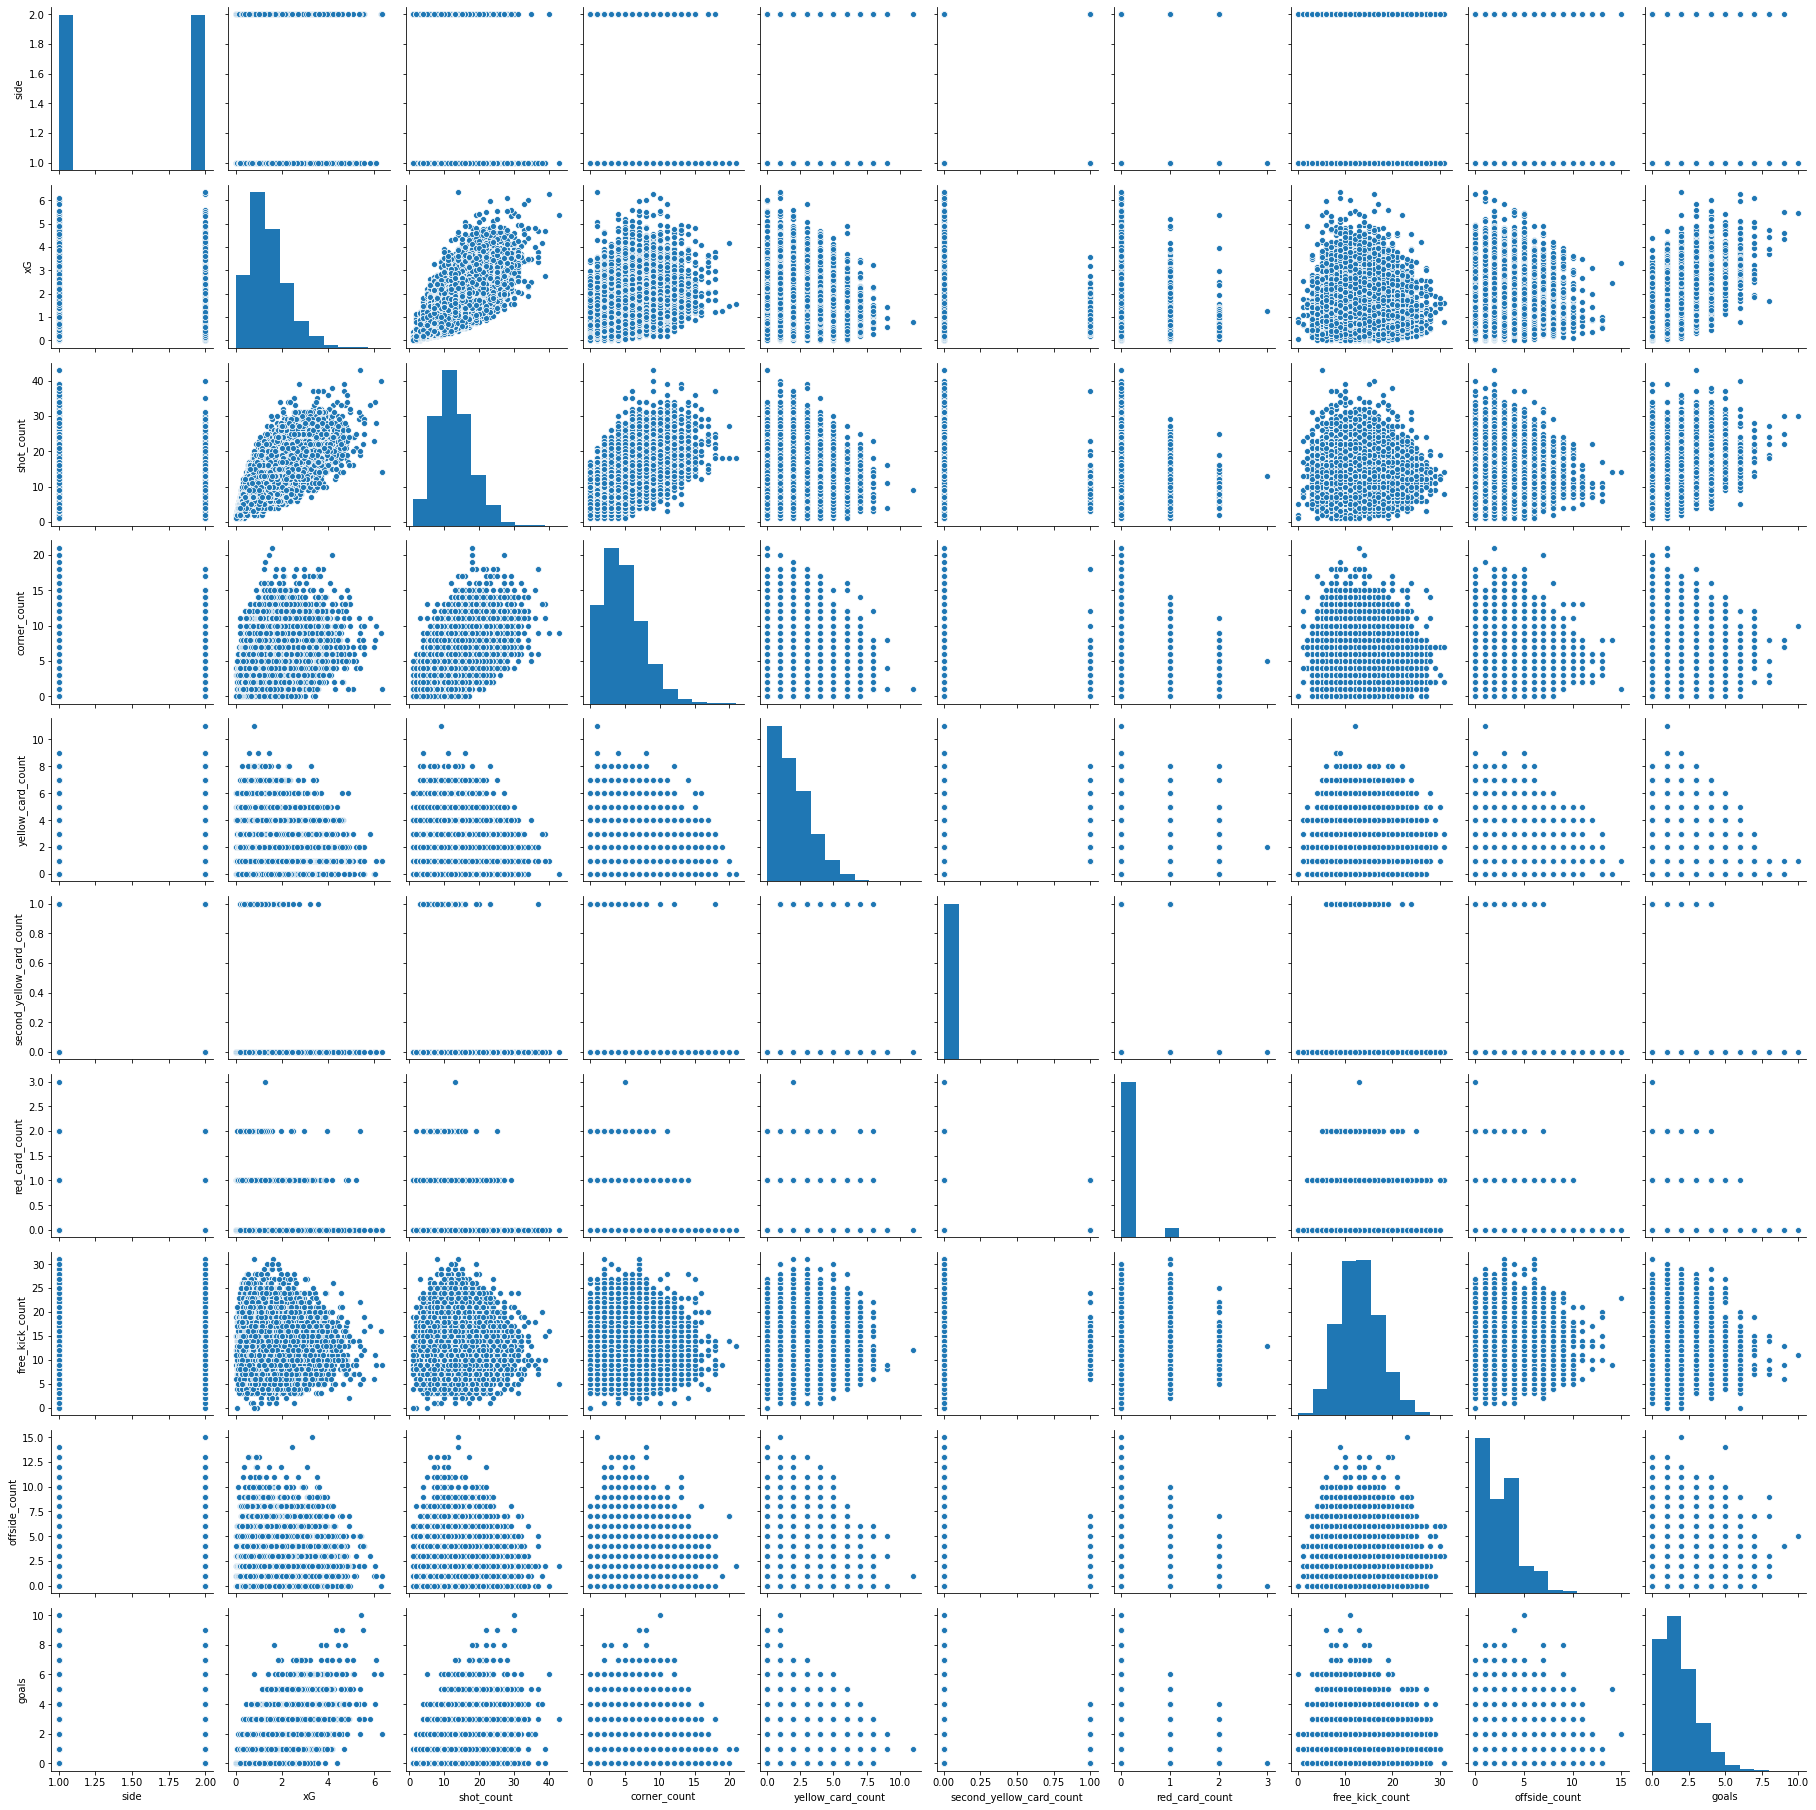

In [17]:
sb.pairplot(fullDataset)

# Regression

## Data preparing

In [18]:
fullDataset['event_team'] = fullDataset['event_team'].apply(hash)
fullX = fullDataset.iloc[:,1:-1]
fullY = fullDataset.iloc[:,-1]

In [19]:
fullDataset

,id_odsp,side,xG,shot_count,corner_count,yellow_card_count,second_yellow_card_count,red_card_count,free_kick_count,offside_count,event_team,goals
0,004f4ING/,1,1.413347,15,9,1,0,1,8,0,-3064239911530014139,0
1,004f4ING/,2,0.453106,6,0,1,0,0,10,3,-5739781230392496148,1
2,00LMl81F/,1,2.949324,24,13,2,0,0,14,0,8823834864807291932,2
3,00LMl81F/,2,1.608309,15,4,3,0,1,10,6,1851914384687039204,3
4,00OX4xFp/,1,1.166929,9,4,1,0,0,18,3,-990753595505285362,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18139,zyKwAQxf/,2,1.218277,13,3,2,0,0,9,2,-6174397139323712403,0
18140,zyrHmI8P/,1,2.183775,9,6,1,0,0,7,1,-6921010163070791426,4
18141,zyrHmI8P/,2,1.008775,9,3,2,0,0,11,3,-2067963959853500115,0
18142,zyzdxP10/,1,1.587103,13,3,1,0,0,12,3,6488132297828080834,2


In [20]:
%%time
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX, fullY, test_size=0.35, random_state=1)
#fullXTest = fullXTest.drop('event_team',axis=1)
#fullXTrain = fullXTrain.drop('event_team',axis=1)
randForest = RandomForestRegressor(n_estimators=5000, max_features='log2')
randForest.fit(fullXTrain, fullYTrain)
print(f'On test we get {randForest.score(fullXTest, fullYTest)}')

On test we get 0.37332794086659715
CPU times: user 1min 55s, sys: 1.38 s, total: 1min 56s
Wall time: 1min 56s


In [24]:
#analyse why this works
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX, fullY, test_size=0.35, random_state=1)
fullXTest = fullXTest.drop('event_team',axis=1)
fullXTrain = fullXTrain.drop('event_team',axis=1)
logisticReg = LogisticRegression(max_iter=1000)
logisticReg.fit(fullXTrain, fullYTrain)
print(f'On test we get {logisticReg.score(fullXTest, fullYTest)}')

On test we get 0.4300110218863171


/home/paulo/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
%%time
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX, fullY, test_size=0.35, random_state=1)
fullXTest = fullXTest.drop('event_team',axis=1)
fullXTrain = fullXTrain.drop('event_team',axis=1)
fullXTest = fullXTest[['xG','shot_count','corner_count','free_kick_count']]
fullXTrain = fullXTrain[['xG','shot_count','corner_count','free_kick_count']]
mlpReg = MLPRegressor(random_state=0, hidden_layer_sizes=(28, 28, 28, 28), max_iter=20000)
mlpReg.fit(fullXTrain, fullYTrain)
res = mlpReg.score(fullXTest, fullYTest)
print(f'On test we get {res}')


On test we get 0.36745726454419037
CPU times: user 2.3 s, sys: 27.6 ms, total: 2.33 s
Wall time: 2.28 s
